# Example: Center of Mass calculation

Prerequisites: 

 * a python3.6 or python3.7 virtualenv with all requirements installed
  * LiberTEM 0.2.0.dev0 or newer -- see [installation instructions from source](https://libertem.github.io/LiberTEM/install.html#installing-from-a-git-clone)
  * ``pip install hyperspy hyperspy_gui_ipywidgets notebook`` for additional dependencies
 * a HDF5 dataset

We disable threading in OpenBLAS because it would interfere with the dask multiprocessing and because OpenBLAS likes to call ``sched_yield`` for no discernable reason

In [1]:
%env OMP_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1

env: OMP_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1


In [2]:
%matplotlib nbagg

Import our dependencies. There may be some warnings about ``hyperspy_gui_traitui`` and so on which can be safely ignored (you do need ``hyperspy_gui_ipywidgets`` though):

In [3]:
from scipy.ndimage import measurements
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import hyperspy.api as hs

from libertem import api

This starts a local cluster that is accessible through ``ctx``. Starting several clusters in parallel is unproblematic because each cluster is rather lightweight and relies on the host file system for caching.

In [4]:
ctx = api.Context()

If you want to run this notebook, you may need to adjust the ``emd_path`` variable and ``hdf5path`` parameter here. This example uses a local HDF5 file as input dataset, but you can use the HDFS DataSet implementation if you want to use your cluster.

In [5]:
raw_path = 'C:/Users/weber/ownCloud/Projects/Open Pixelated STEM framework/Data/EMPAD/scan_11_x256_y256.raw'
emd_path = 'C:/Users/weber/ownCloud/Projects/Open Pixelated STEM framework/Data/EMPAD/scan_11_x256_y256.emd'

hdf5path = 'experimental/science_data/data'

# we keep this as an example how to load raw
raw_ds = ctx.load(
    'raw',
    path=raw_path,
    tileshape=(256, 256, 128, 128),
    scan_size=(256,256),
    dtype="float32",
    detector_size_raw=(130,128),
    crop_detector_to=(128,128)
)

ds = ctx.load(
    'hdf5',
    path=emd_path,
    ds_path=hdf5path,
    tileshape=(1,8,128,128)
)
(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = np.array((detector_y, detector_x))

Now, we create a center of mass (COM) analysis. We set the mask radius to `None` (default) to use the entire frame.

In [6]:
cx = detector_x/2
cy = detector_y/2
analysis = ctx.create_com_analysis(dataset=ds, cx=cx, cy=cy, mask_radius=None)

We kick off the computation:

In [7]:
%time result = ctx.run(analysis)

Wall time: 18.4 s


Let's show the result:

In [8]:
print(result)

[<AnalysisResult: field>, <AnalysisResult: magnitude>, <AnalysisResult: divergence>, <AnalysisResult: x>, <AnalysisResult: y>]


In [9]:
print(result.field)

title: field
desc: cubehelix colorwheel visualization
key: field
raw_data: (array([[ 0.27876282, -0.39032745,  1.1497574 , ..., -0.6885414 ,
        -0.809845  , -1.0292473 ],
       [ 0.30957794,  0.55506134,  0.9525528 , ..., -0.77316666,
        -0.907341  , -1.1169319 ],
       [ 0.00855255,  0.21022797,  0.95464325, ..., -1.0613747 ,
        -1.3062172 , -1.4584389 ],
       ...,
       [ 0.31815338,  1.0073929 ,  0.480011  , ...,  0.15502167,
         0.0266571 , -0.2951088 ],
       [ 0.6370468 ,  0.64837646, -0.16071701, ..., -0.05502319,
         0.01834869, -0.28866577],
       [ 0.46064758,  0.48744202, -0.5629692 , ..., -0.2944603 ,
         0.23345947,  0.24784088]], dtype=float32), array([[-0.80864716, -0.90322113, -0.7465553 , ..., -0.8712616 ,
        -0.50823593, -0.19400787],
       [-0.5822067 , -0.77360153, -1.317749  , ..., -1.5244293 ,
        -0.86782837, -0.5738716 ],
       [-0.6904297 , -0.92946243, -0.884922  , ..., -1.9639244 ,
        -1.4774895 , -0.931438

We show the default visualization for field and for magnitude.

<IPython.core.display.Javascript object>


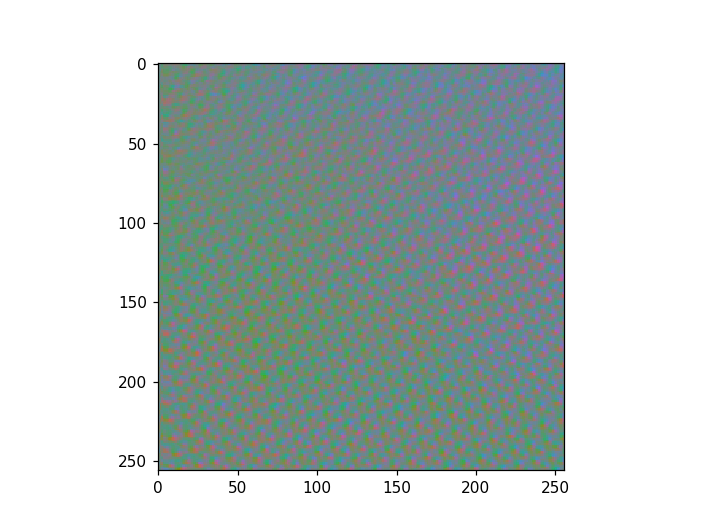

<IPython.core.display.Javascript object>


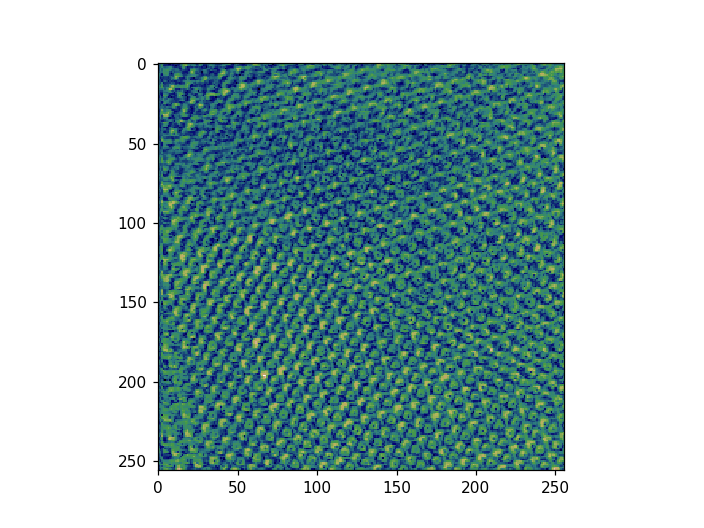

In [10]:
fig, axes = plt.subplots()
axes.imshow(result.field.visualized)
fig, axes = plt.subplots()
axes.imshow(result.magnitude.visualized)

Let's create a HyperSpy signal that contains the `(x, y)` pairs as signal for each scan position:

<IPython.core.display.Javascript object>


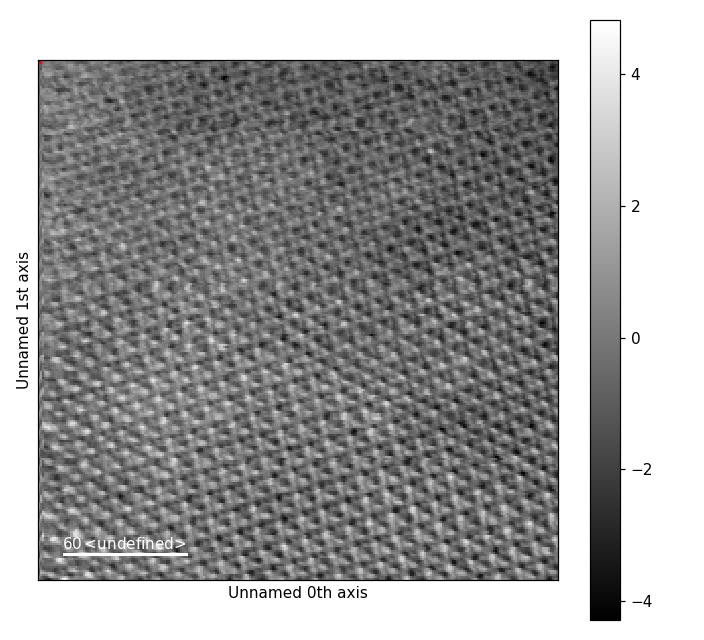

<IPython.core.display.Javascript object>


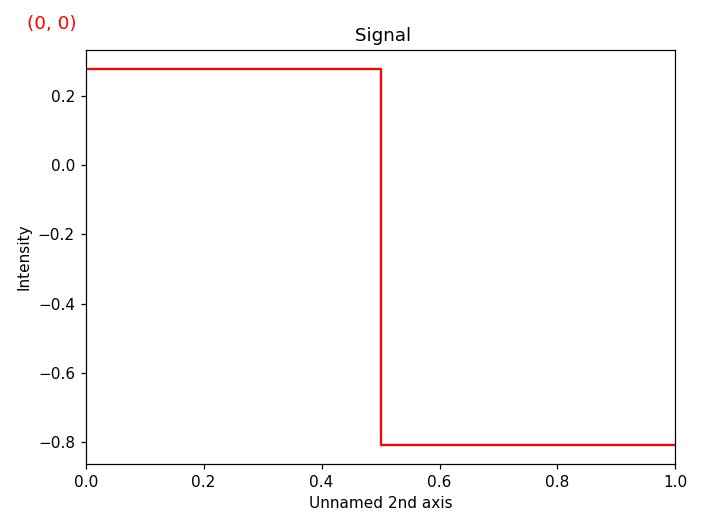

In [11]:
centers = hs.signals.Signal1D(np.dstack((result.x.raw_data, result.y.raw_data)))
centers.plot()

Ok, now that we have our results, let's see how we compare to the ``scipy`` implementation. Let's use HyperSpy to load the dataset lazily (``optimize=False`` because of the lazy signal):

In [12]:
raw_data = hs.load(emd_path, lazy=True).as_signal2D(image_axes=(0, 1), optimize=False)

Let's have a look at one frame, plot it and see how the result compares to ours. We add `cx` resp. `cy` to our coordinates because we've set these as reference center for our center of mass calculation.

<IPython.core.display.Javascript object>


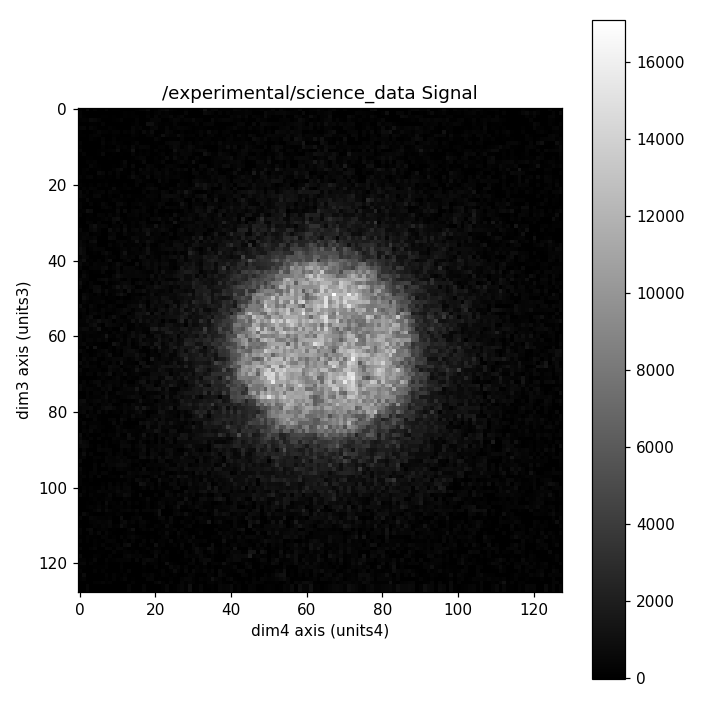

scipy center: x=64.278758, y=63.191338
our center:   x=64.278763, y=63.191353
difference from scipy: x=-0.000005, y=-0.000014


In [13]:
frame_coords = (0, 0)
frame = raw_data.inav[frame_coords]
frame.plot(navigator=None)
frame_data = frame.data.compute()
center_y, center_x = measurements.center_of_mass(frame_data)


# marker = hs.plot.markers.point(x=center_x, y=center_y, color='red')
# frame.add_marker(marker) # -> crashes for some reason


print("scipy center: x=%.6f, y=%.6f" % (center_x, center_y))
print("our center:   x=%.6f, y=%.6f" % (centers.inav[frame_coords].isig[0].data[0] + cx,
                                      centers.inav[frame_coords].isig[1].data[0] + cy))
print("difference from scipy: x=%.6f, y=%.6f" % (
    (center_x - centers.inav[frame_coords].isig[0].data[0] - cx),
    (center_y - centers.inav[frame_coords].isig[1].data[0] - cy)
))